In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil

import cartopy.crs as ccrs
import shapely
import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif
import pandas as pd

from lmatools.io.LMA_h5_file import LMAh5File
from lmatools.coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem, MapProjection


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Description of fields:

Storm_id: The ID of the storm identified. A storm is defined by a continuous period where cells were identified by TINT.

Scan: The scan number for the storm

Time: time of scan

Uid: The cell id

Isolated: Is the cell isolated?

Area: Area of cell in square km

Vol: 3d volume of cell in km^3

Grid_x: x location in terms of grid indices when using the grid specification supplied in the earlier code

Grid_y: y location in terms of grid indices when using the grid specification supplied in the earlier code

Lat: Cell center latitude

Lon: Cell center longitude

Max: Reflectivity maximum

Max_alt: The maximum altitude of the cell

Kdp_pct: Mean KDP in KDP column

Zdr_pct: Mean ZDR in ZDR column

Zhh_pct: Mean reflectivity in KDP column

`csu_dsd` - DSD parameter estimation via several different methodologies

`csu_kdp` - An FIR-based KDP estimation algorithm

Kdp_pet: KDP potential energy

Zdr_pet: ZDR potential energy

Zhh_pet: Reflectivity potential energy


In [2]:
import glob
filenames = sorted(glob.glob('/home/jessica/tracer/Tgri*.nc'))
filenames
# radar = pyart.io.read_cfradial(arq[0])

['/home/jessica/tracer/Tgrid_000.nc',
 '/home/jessica/tracer/Tgrid_001.nc',
 '/home/jessica/tracer/Tgrid_002.nc',
 '/home/jessica/tracer/Tgrid_003.nc',
 '/home/jessica/tracer/Tgrid_004.nc',
 '/home/jessica/tracer/Tgrid_005.nc',
 '/home/jessica/tracer/Tgrid_006.nc',
 '/home/jessica/tracer/Tgrid_007.nc',
 '/home/jessica/tracer/Tgrid_008.nc',
 '/home/jessica/tracer/Tgrid_009.nc',
 '/home/jessica/tracer/Tgrid_010.nc',
 '/home/jessica/tracer/Tgrid_011.nc',
 '/home/jessica/tracer/Tgrid_012.nc',
 '/home/jessica/tracer/Tgrid_013.nc',
 '/home/jessica/tracer/Tgrid_014.nc',
 '/home/jessica/tracer/Tgrid_015.nc',
 '/home/jessica/tracer/Tgrid_016.nc',
 '/home/jessica/tracer/Tgrid_017.nc',
 '/home/jessica/tracer/Tgrid_018.nc',
 '/home/jessica/tracer/Tgrid_019.nc',
 '/home/jessica/tracer/Tgrid_020.nc',
 '/home/jessica/tracer/Tgrid_021.nc',
 '/home/jessica/tracer/Tgrid_022.nc',
 '/home/jessica/tracer/Tgrid_023.nc']

In [3]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

# The cells we're interested in look a bit small. Let's reduce the minimum size threshold.
tracks_obj.params['MIN_SIZE'] = 4
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12
Writing tracks for scan 13
Writing tracks for scan 14
Writing tracks for scan 15
Writing tracks for scan 16
Writing tracks for scan 17
Writing tracks for scan 18
Writing tracks for scan 19
Writing tracks for scan 20
Writing tracks for scan 21
Writing tracks for scan 22
Writing tracks for scan 23


time elapsed 1.3 minutes


In [5]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks

time   grid_x   grid_y      lon      lat   area  \
scan uid                                                                      
0    0   2017-07-08 20:31:36.294  125.800   19.400 -96.3344  27.3886   10.0   
     1   2017-07-08 20:31:36.294  191.761   33.761 -95.6668  27.5281   67.0   
     2   2017-07-08 20:31:36.294  100.500   37.300 -96.6000  27.5477   10.0   
     3   2017-07-08 20:31:36.294  209.625   60.250 -95.4852  27.7626   24.0   
     4   2017-07-08 20:31:36.294    3.400   67.500 -97.5900  27.8116   20.0   
...                          ...      ...      ...      ...      ...    ...   
23   36  2017-07-08 22:37:42.446  430.670  489.868 -93.1676  31.6166  394.0   
     245 2017-07-08 22:37:42.446  455.376  482.055 -92.9159  31.5408  109.0   
     92  2017-07-08 22:37:42.446  172.960  483.820 -95.8914  31.5738   50.0   
     227 2017-07-08 22:37:42.446   89.793  484.828 -96.7674  31.5746   29.0   
     178 2017-07-08 22:37:42.446  165.738  494.024 -95.9661  31.6633   42.0   

             vol        max  max_alt  isolated  
scan uid                                        
0    0      13.0  38.000000      8.5     False  
     1     240.0  51.498310      6.5      True  
     2      21.0  38.327461      8.5      True  
     3      75.5  45.192131      9.0      True  
     4      35.0  41.880177     11.0      True  
...          ...        ...      ...       ...  
23   36   1977.5  49.824013     15.0     False  
     245   526.0  52.754990     11.5     False  
     92    186.5  44.901077      7.5     False  
     227   104.0  42.244267      9.5      True  
     178   165.5  45.668621      8.5     False  

[866 rows x 10 columns]

In [25]:
tracks_obj.tracks.xs(13, level = 'scan')

,time,grid_x,grid_y,lon,lat,area,vol,max,max_alt,isolated
uid,,,,,,,,,,
101,2017-07-08 21:42:27.339,352.250,32.250,-94.0447,27.5074,4.0,3.0,39.252464,3.5,True
110,2017-07-08 21:42:27.339,34.323,148.677,-97.2901,28.5453,31.0,102.5,42.751408,7.5,False
142,2017-07-08 21:42:27.339,16.733,154.200,-97.4651,28.5873,15.0,46.0,36.405121,8.0,False
143,2017-07-08 21:42:27.339,174.400,254.200,-95.8641,29.5056,5.0,8.5,37.968227,6.5,True
112,2017-07-08 21:42:27.339,254.364,272.364,-95.0373,29.6697,11.0,13.0,50.500000,4.0,False
88,2017-07-08 21:42:27.339,214.455,309.636,-95.4526,30.0110,11.0,20.0,43.680668,3.5,False
114,2017-07-08 21:42:27.339,207.222,310.111,-95.5253,30.0107,9.0,15.0,44.500000,5.0,False
132,2017-07-08 21:42:27.339,494.532,338.452,-92.5282,30.2390,124.0,607.5,54.000000,13.5,False
144,2017-07-08 21:42:27.339,486.000,336.714,-92.6221,30.2317,7.0,9.5,34.432053,8.0,False


In [6]:
# Let's find the cells that were tracked for the most frames
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:16]

uid
24     24
36     24
27     24
33     21
67     20
26     18
92     17
100    16
106    15
107    15
61     14
83     14
16     13
40     13
43     12
132    12
dtype: int64

In [7]:
# We can view the attributes of this cell throughout its lifetime
tracks_obj.tracks.xs('24', level='uid')

,time,grid_x,grid_y,lon,lat,area,vol,max,max_alt,isolated
scan,,,,,,,,,,
0,2017-07-08 20:31:36.294,430.190,405.066,-93.1932,30.8526,316.0,1585.0,56.997749,12.0,False
1,2017-07-08 20:37:23.586,429.847,402.666,-93.1936,30.8346,353.0,1811.0,53.770519,11.5,False
2,2017-07-08 20:43:11.009,432.215,398.538,-93.1733,30.7983,353.0,1893.5,56.673004,12.0,False
3,2017-07-08 20:48:58.333,431.357,396.683,-93.1841,30.7805,417.0,2319.0,58.000595,15.0,False
4,2017-07-08 20:54:45.562,431.918,395.156,-93.1740,30.7624,404.0,2433.0,59.300323,15.0,False
5,2017-07-08 21:00:33.261,430.728,392.717,-93.1848,30.7445,463.0,2659.0,57.598358,14.5,False
6,2017-07-08 21:06:20.576,430.830,391.699,-93.1850,30.7355,482.0,2832.0,57.166210,14.5,False
7,2017-07-08 21:12:07.965,431.139,390.626,-93.1852,30.7265,468.0,2582.0,53.350044,11.5,False
8,2017-07-08 21:17:28.855,430.156,389.695,-93.1958,30.7177,505.0,2578.0,54.852268,11.5,False


(-94.8, -94.15)

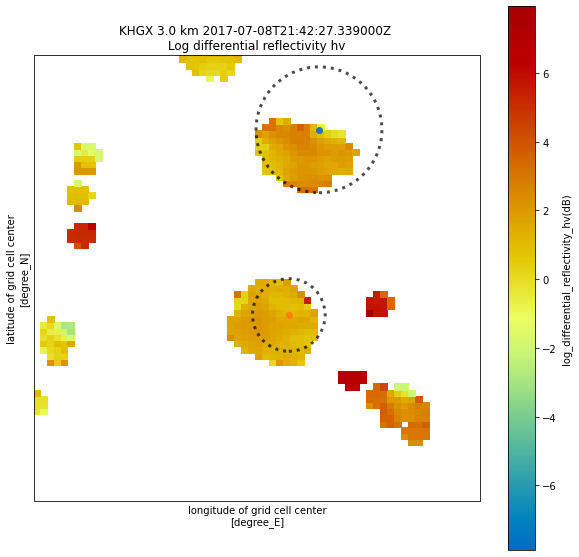

In [99]:
radar = pyart.io.read_grid('/home/jessica/tracer/Tgrid_013.nc')
display = pyart.graph.GridMapDisplay(radar)

# Setting projection, figure size, and panel sizes.
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[10, 10])

# Panel 1: PPI plot of the second tilt.
ax = fig.add_subplot(111, projection=projection)
display.plot_grid('differential_reflectivity', 6,
                  projection=projection,
                  cmap='pyart_HomeyerRainbow')

plt.scatter(-94.3846,31.2418)
plt.scatter(-94.4285,30.9722)

# 121
from matplotlib.patches import Circle, PathPatch
circle = Circle((-94.3846,31.2418), np.sqrt(38)/100 + 0.03 , facecolor='none',
                  edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
ax.add_patch(circle)

# 126
circle = Circle((-94.4285,30.9722), np.sqrt(28)/100 , facecolor='none',
                  edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
ax.add_patch(circle)

# plt.scatter(XRAD,YRAD)
plt.scatter(XLMA,YLMA)

# plt.ylim(28,32)
# plt.xlim(-97,-92)
plt.ylim(30.702, 31.350)
plt.xlim(-94.80, -94.15)

(-97.0, -92.0)

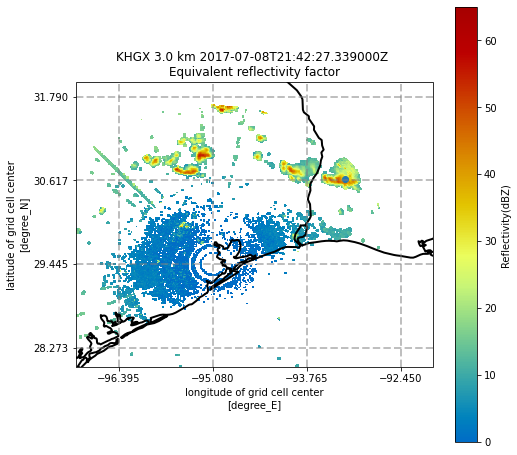

In [104]:
radar = pyart.io.read_grid('/home/jessica/tracer/Tgrid_013.nc')
display = pyart.graph.GridMapDisplay(radar)

# Setting projection, figure size, and panel sizes.
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[8, 8])

# Panel 1: PPI plot of the second tilt.
ax = fig.add_subplot(111, projection=projection)
display.plot_grid('reflectivity', 6, vmin=0, vmax=65,
                  projection=projection,
                  cmap='pyart_HomeyerRainbow')

plt.scatter(-93.2287,30.6372)

plt.ylim(28,32)
plt.xlim(-97,-92)

(-95.08, -92.5)

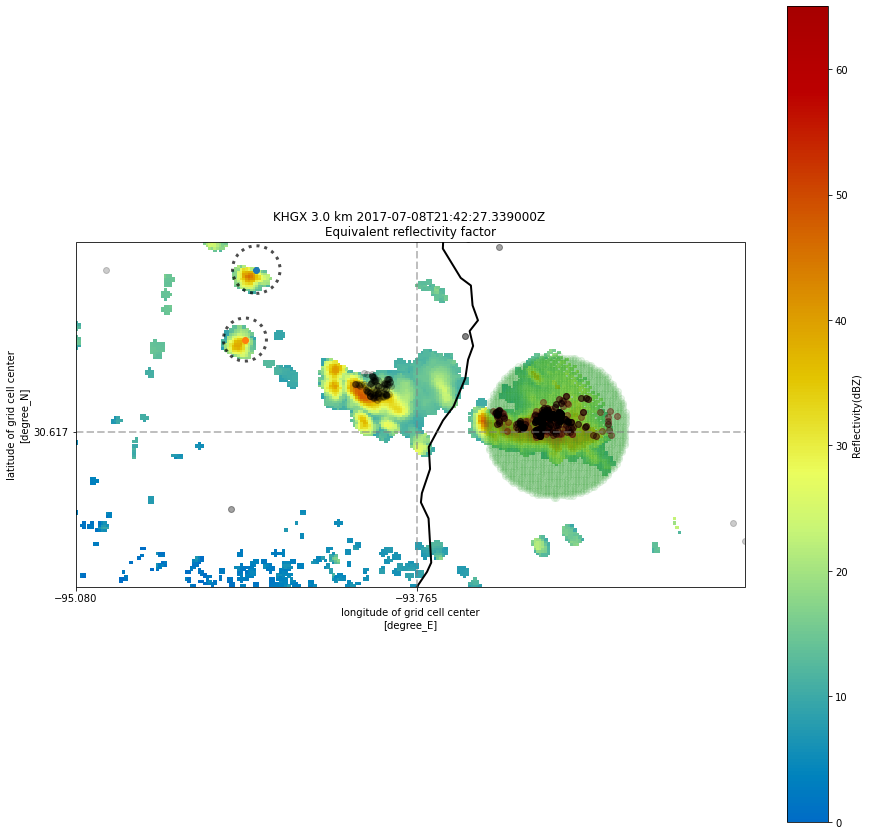

In [163]:
radar = pyart.io.read_grid('/home/jessica/tracer/Tgrid_013.nc')
display = pyart.graph.GridMapDisplay(radar)

# Setting projection, figure size, and panel sizes.
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[15, 15])

# Panel 1: PPI plot of the second tilt.
ax = fig.add_subplot(111, projection=projection)
display.plot_grid('reflectivity', 6, vmin=0, vmax=65,
                  projection=projection,
                  cmap='pyart_HomeyerRainbow')

# clon, clat = -94.3846,31.2418
# carea = 38

# plt.scatter(clon, clat, color = 'gray')

# from matplotlib.patches import Circle, PathPatch, Rectangle
# circle = Circle((clon, clat), np.sqrt(carea)/100 + 0.03 , facecolor='none',
#                   edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
# square = Rectangle(xy, width, height, facecolor='none', edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':'
# ax.add_patch(circle)
# ax.add_patch(square)

plt.scatter(-94.3846,31.2418)
plt.scatter(-94.4285,30.9722)

# 121
from matplotlib.patches import Circle, PathPatch
circle = Circle((-94.3846,31.2418), np.sqrt(38)/100 + 0.03 , facecolor='none',
                  edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
ax.add_patch(circle)

# 126
circle = Circle((-94.4285,30.9722), np.sqrt(28)/100 + 0.03 , facecolor='none',
                  edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
ax.add_patch(circle)

plt.scatter(XRAD,YRAD, alpha = 0.1)
plt.scatter(XLMA,YLMA, alpha = 0.3)

for i in np.arange(len(ids)):
    flash = one_flash(events_all, ids[i])
    flash = flash.sort_values(by=['time'])
    plt.scatter(flash.lon.values,flash.lat.values, color = 'black', alpha = 0.2)

plt.ylim(30.02, 31.350)
plt.xlim(-95.080, -92.5)

## CIRCULAR

In [110]:
clon, clat = -94.4285,30.9722
clon, clat = -93.2287,30.6372
carea = 505


from shapely.geometry import Polygon, Point, MultiPoint

cell_center = Point(clon, clat)
cell_poly = cell_center.buffer((np.sqrt(carea)/100) + 0.05)
# list(cell_poly.exterior.coords)

## RADAR

In [57]:
np.shape(radar.get_point_longitude_latitude(level = 6, edges = 'False'))

(2, 502, 502)

In [59]:
radar.get_point_longitude_latitude(level = 6, edges = 'True')[0].max()

-92.43137215698872

In [ ]:
plt.scatter(XRAD,YRAD)

In [43]:
grid_x = radar.get_point_longitude_latitude(level = 6, edges = 'False')[0][:,:].flatten()  #### Check this on source because the centers have the edges dimension
grid_y = radar.get_point_longitude_latitude(level = 6, edges = 'False')[1][:,:].flatten()

In [111]:
# -- 
radar_shp = MultiPoint(tuple(np.vstack((grid_x, grid_y)).transpose()))
XRAD = [] 
YRAD = []
for i in np.arange(len(grid_x)):
    if cell_poly.contains(radar_shp[i]) == True:
        XRAD.append(np.asarray(radar_shp[i].coords[0])[0])
        YRAD.append(np.asarray(radar_shp[i].coords[0])[1])
XRAD = np.asarray(XRAD)
YRAD = np.asarray(YRAD)

In [ ]:
np.ma.getdata(radar.fields['differential_reflectivity']['data'])[3].flatten()

In [106]:
np.shape(np.ma.getdata(radar.fields['differential_reflectivity']['data'])[6])

-7.875

## LIGHTNING

In [68]:
from nbe_cand import search_files, potential_nbe, closest_lma_rhi_time, one_flash, loc_1source, loc_1source_cs   
import datetime
files = search_files(base + 'h5_files/2017/Jul/08/', datetime.datetime(2017, 7, 8, 21, 42), datetime.datetime(2017, 7, 8, 21, 47))

[datetime.datetime(2017, 7, 8, 0, 0)] ['LMA_170708_000000_60'] {'LMA_170708_000000_60': {'start_time': datetime.datetime(2017, 7, 8, 0, 0), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
[datetime.datetime(2017, 7, 8, 0, 1)] ['LMA_170708_000100_60'] {'LMA_170708_000100_60': {'start_time': datetime.datetime(2017, 7, 8, 0, 1), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
[datetime.datetime(2017, 7, 8, 0, 2)] ['LMA_170708_000200_60'] {'LMA_170708_000200_60': {'start_time': datetime.datetime(2017, 7, 8, 0, 2), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
[datetime.datetime(2017, 7, 8, 0, 3)] ['LMA_170708_000300_60'] {'LMA_170708_000300_60': {'start_time': datetime.datetime(2017, 7, 8, 0, 3), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
[datetime.datetime(2017, 7, 8, 0, 4)] ['LMA_170708_000400_60'] {'LMA_170708_000400_60': {'start_time': datetime.datetime(2017, 7, 8, 0, 4), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
[datetime.datetime(2017, 7, 8, 0, 5)] ['

In [69]:
files

['/home/jessica/gridded/h5_files/2017/Jul/08/HSTNLMA_170708_214200_0060.dat.flash.h5',
 '/home/jessica/gridded/h5_files/2017/Jul/08/HSTNLMA_170708_214300_0060.dat.flash.h5',
 '/home/jessica/gridded/h5_files/2017/Jul/08/HSTNLMA_170708_214400_0060.dat.flash.h5',
 '/home/jessica/gridded/h5_files/2017/Jul/08/HSTNLMA_170708_214500_0060.dat.flash.h5',
 '/home/jessica/gridded/h5_files/2017/Jul/08/HSTNLMA_170708_214600_0060.dat.flash.h5']

In [183]:
import pandas as pd
lma = LMAh5File(files[0])
events_all, flashes_all = lma.data_for_table(lma.table_names[0])
flashes_all = pd.DataFrame(flashes_all)
events_all = pd.DataFrame(events_all)
for file in files[1:]:
    lma = LMAh5File(file)
    events, flashes = lma.data_for_table(lma.table_names[0])
    flashes = pd.DataFrame(flashes)
    events = pd.DataFrame(events)
    ### GAMBIARRA #####
    flashes.flash_id = flashes.flash_id.values + 10000
    events.flash_id = events.flash_id.values + 10000
    ###################
    flashes_all = flashes_all.append(flashes, ignore_index=True)
    events_all = events_all.append(events, ignore_index=True)

[datetime.datetime(2017, 7, 8, 21, 42)] ['LMA_170708_214200_60'] {'LMA_170708_214200_60': {'start_time': datetime.datetime(2017, 7, 8, 21, 42), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
data for table dt = {0} 0.0
[datetime.datetime(2017, 7, 8, 21, 43)] ['LMA_170708_214300_60'] {'LMA_170708_214300_60': {'start_time': datetime.datetime(2017, 7, 8, 21, 43), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
data for table dt = {0} 0.0
[datetime.datetime(2017, 7, 8, 21, 44)] ['LMA_170708_214400_60'] {'LMA_170708_214400_60': {'start_time': datetime.datetime(2017, 7, 8, 21, 44), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
data for table dt = {0} 0.0
[datetime.datetime(2017, 7, 8, 21, 45)] ['LMA_170708_214500_60'] {'LMA_170708_214500_60': {'start_time': datetime.datetime(2017, 7, 8, 21, 45), 'start_date': datetime.datetime(2017, 7, 8, 0, 0)}}
data for table dt = {0} 0.0
[datetime.datetime(2017, 7, 8, 21, 46)] ['LMA_170708_214600_60'] {'LMA_170708_214600_60': {'start_time':

In [222]:
xlma = events_all.lon.values
ylma = events_all.lat.values
lma_shp = MultiPoint(tuple(np.vstack((xlma, ylma)).transpose()))
XLMA = [] 
YLMA = []
idx = []
for i in np.arange(len(xlma)):
    if cell_poly.contains(lma_shp[i]) == True:
        XLMA.append(np.asarray(lma_shp[i].coords[0])[0])
        YLMA.append(np.asarray(lma_shp[i].coords[0])[1])
        idx.append(i)
XLMA = np.asarray(XLMA)
YLMA = np.asarray(YLMA)
idx = np.asarray(idx)

In [223]:
ids = []
for i in idx:
    ids.append(events_all.flash_id[i])

In [224]:
np.unique(ids)

array([    4,    87,    88,    89,    90,    91,   115,   116,   117,
         118,   119,   120,   185,   260,   261,   313,   352,   438,
         439,   440,   441,   442,   443,   444, 10018, 10032, 10049,
       10050, 10051, 10054, 10057, 10059, 10060, 10061, 10062, 10063,
       10064, 10065, 10070, 10071, 10074, 10075, 10077, 10081, 10082,
       10083, 10084, 10085, 10086, 10110, 10111, 10112, 10114, 10115,
       10134, 10135, 10146, 10147, 10149, 10153, 10155, 10156, 10157,
       10159, 10167, 10172, 10173, 10174, 10175, 10176, 10178, 10179,
       10180, 10181, 10182, 10183, 10184, 10198, 10211, 10212, 10213,
       10218, 10220, 10221, 10226, 10227, 10229, 10245, 10246, 10247,
       10248, 10249, 10250, 10251, 10252, 10254, 10272, 10273, 10281,
       10282, 10290, 10291, 10292, 10293, 10295, 10296, 10303, 10304,
       10306, 10307, 10309, 10328, 10329, 10330, 10332, 10333, 10334,
       10335, 10336, 10337, 10369, 10385, 10387, 10388, 10389, 10393,
       10395, 10396,

In [188]:
flash

,alt,charge,chi2,flash_id,lat,lon,mask,power,stations,time
6523,9465.419922,0,0.13,10473,30.687075,-93.452202,b'0x1a4c',11.900000,6,78415.590800
6522,10233.110352,0,0.01,10473,30.685627,-93.453613,b'0x1b4c',16.700001,7,78415.606046
6520,10149.049805,0,0.15,10473,30.698521,-93.452301,b'0x1a4c',11.100000,6,78415.638169
6521,10050.750000,0,1.00,10473,30.701387,-93.449982,b'0x1b6c',22.299999,8,78415.650716


In [159]:
# -- FLASH
# -- Select the flashes I want
for i in np.arange(len(ids)):
    flash = one_flash(events_all, ids[0])
    flash = flash.sort_values(by=['time'])
    plt.scatter(flash.lon.values,flash.lat.values)



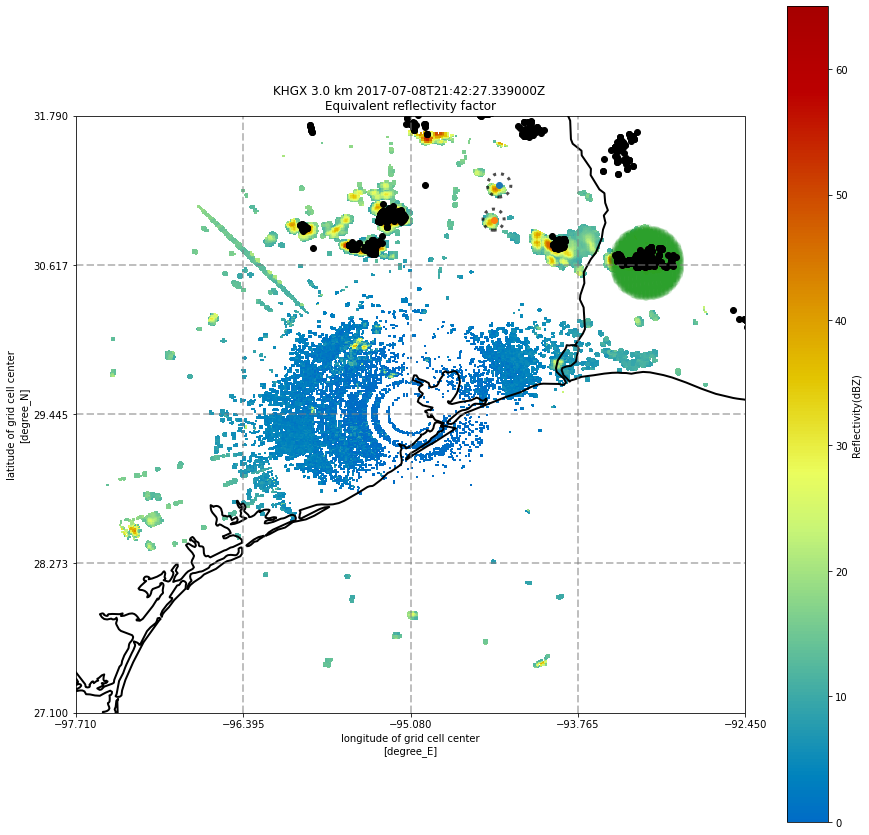

In [219]:
radar = pyart.io.read_grid('/home/jessica/tracer/Tgrid_013.nc')
display = pyart.graph.GridMapDisplay(radar)

# Setting projection, figure size, and panel sizes.
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[15, 15])

# Panel 1: PPI plot of the second tilt.
ax = fig.add_subplot(111, projection=projection)
display.plot_grid('reflectivity', 6, vmin=0, vmax=65,
                  projection=projection,
                  cmap='pyart_HomeyerRainbow')

# clon, clat = -94.3846,31.2418
# carea = 38

# plt.scatter(clon, clat, color = 'gray')

# from matplotlib.patches import Circle, PathPatch, Rectangle
# circle = Circle((clon, clat), np.sqrt(carea)/100 + 0.03 , facecolor='none',
#                   edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
# square = Rectangle(xy, width, height, facecolor='none', edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':'
# ax.add_patch(circle)
# ax.add_patch(square)

plt.scatter(-94.3846,31.2418)
plt.scatter(-94.4285,30.9722)

# 121
from matplotlib.patches import Circle, PathPatch
circle = Circle((-94.3846,31.2418), np.sqrt(38)/100 + 0.03 , facecolor='none',
                  edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
ax.add_patch(circle)

# 126
circle = Circle((-94.4285,30.9722), np.sqrt(28)/100 + 0.03 , facecolor='none',
                  edgecolor = 'black', linewidth = 3, alpha=0.7, linestyle = ':')
ax.add_patch(circle)

plt.scatter(XRAD,YRAD, alpha = 0.1)
plt.scatter(XLMA,YLMA, alpha = 0.3)

for i in ids:
    flash = one_flash(events_all, i)
#     flash = flash.sort_values(by=['time'])
    plt.scatter(flash.lon.values,flash.lat.values, color = 'black')
    
# plt.scatter(xlma,ylma)

# plt.ylim(30.02, 31.350)
# plt.xlim(-95.080, -92.5)

In [203]:
ids

[4,
 87,
 88,
 89,
 90,
 91,
 115,
 116,
 117,
 118,
 119,
 119,
 120,
 185,
 185,
 260,
 261,
 313,
 352,
 438,
 438,
 439,
 440,
 441,
 442,
 443,
 443,
 443,
 443,
 443,
 443,
 443,
 443,
 443,
 443,
 443,
 443,
 444,
 444,
 444,
 444,
 444,
 444,
 444,
 10032,
 10077,
 10077,
 10077,
 10077,
 10077,
 10077,
 10077,
 10077,
 10077,
 10081,
 10172,
 10172,
 10173,
 10174,
 10175,
 10226,
 10227,
 10229,
 10229,
 10247,
 10248,
 10249,
 10250,
 10250,
 10250,
 10251,
 10252,
 10254,
 10309,
 10328,
 10329,
 10329,
 10329,
 10329,
 10330,
 10422,
 10422,
 10054,
 10057,
 10057,
 10057,
 10059,
 10059,
 10059,
 10059,
 10060,
 10060,
 10061,
 10062,
 10063,
 10064,
 10065,
 10065,
 10134,
 10135,
 10135,
 10135,
 10135,
 10153,
 10156,
 10156,
 10157,
 10159,
 10211,
 10212,
 10218,
 10218,
 10218,
 10303,
 10304,
 10306,
 10307,
 10332,
 10332,
 10332,
 10333,
 10334,
 10335,
 10335,
 10336,
 10336,
 10337,
 10393,
 10395,
 10395,
 10396,
 10398,
 10398,
 10401,
 10460,
 10460,
 10460,